# Вспомогательный код

Чтобы результаты экспериментов воспроизводились, зафиксируем seed's:

In [ ]:
import torch
import random
import numpy as np


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


set_random_seed(42)

# Задание 1. RNN, LSTM и GRU

Используя код из лекции, попробуйте обучить RNN с размерностью скрытого состояния `hidden_size=2` на следующих периодичных данных и визуализируйте результат.

In [ ]:
import math
import torch
import random
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader, random_split

Определим `input_size` и `hidden_size`:

In [ ]:
input_size = 1
hidden_size = 2

Функция для визуализации на базе материала из лекции:

In [ ]:
def display(data, pred=None, vert=None, title="Prediction"):
    data = np.array(data).reshape((len(data), 1))
    plt.figure(figsize=(12, 6))
    plt.plot(data, label="Some periodic function")
    if pred is not None:
        plt.plot(pred, label=title)
    if vert is not None:
        plt.axvline(x=vert, c="r", linestyle="--")
    plt.legend()
    plt.grid()
    plt.show()

Генерация данных для обучения:

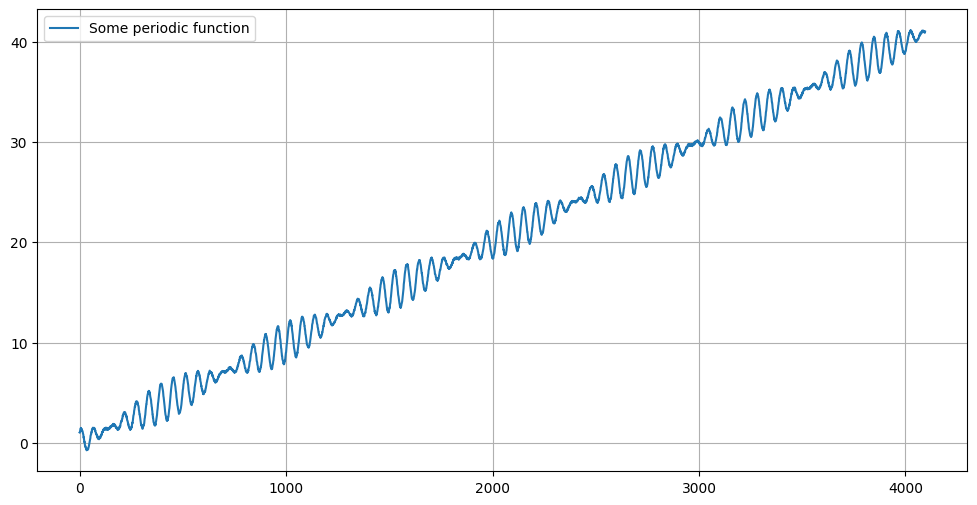

In [ ]:
training_data = []
for i in range(4096):
    training_data.append(
        math.sin(i / 10) + math.cos((i) / 9) + i / 100 + (random.random() - 0.5) / 5
    )

display(training_data)

**Подготовка данных**



Разделите данные на подвыборки.

In [ ]:
data = np.array(training_data)
train_size = int(len(data) * 0.8)

train_data = data[:train_size]
test_data = data[train_size:]

Данные имеют ярко выраженный линейный тренд,
["A time series with a trend is called non-stationary."](https://machinelearningmastery.com/time-series-trends-in-python/)

Удалим его, используя функцию [detrend](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html) из `scipy.signal`.

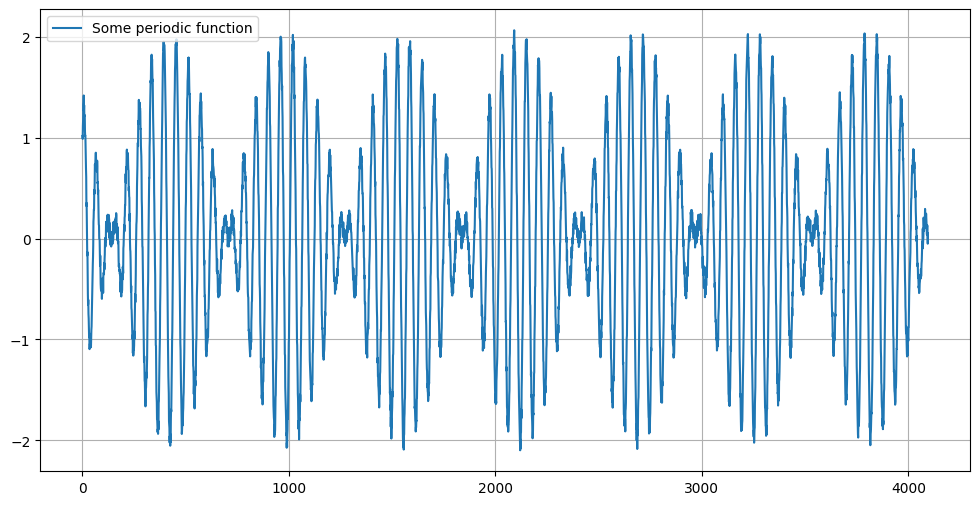

In [ ]:
from scipy.signal import detrend

stationary_data = detrend(training_data)
display(stationary_data)

Сохраним тренд, чтобы иметь возможность восстановить данные:

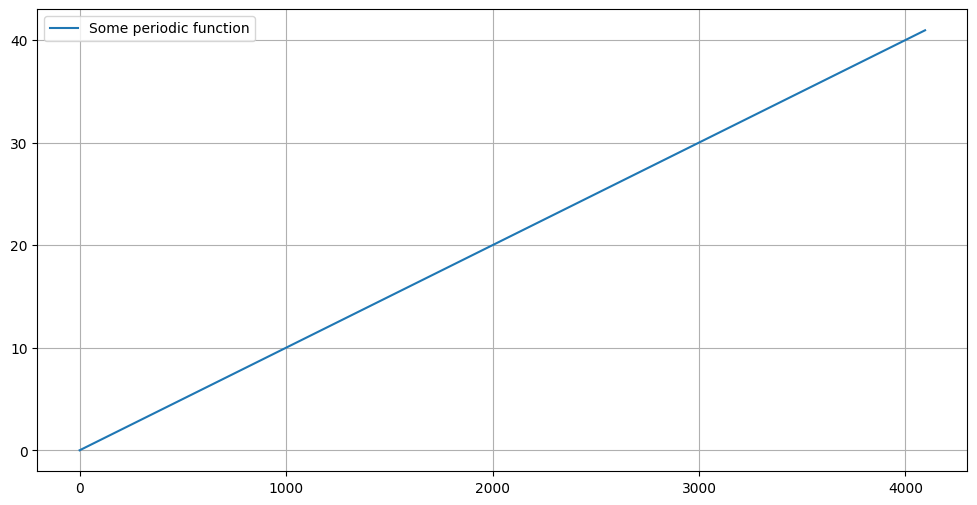

In [ ]:
trend = training_data - stationary_data
display(trend)

А теперь сделайте это для ваших подвыборок данных, на которых вы далее будете учить, валидировать и тренировать модель.

In [ ]:
import torch
import numpy as np

def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length):
        _x = data[i : (i + seq_length)]
        _y = data[i + seq_length]
        x.append(_x)
        y.append(_y)

    return torch.Tensor(np.array(x)), torch.Tensor(np.array(y))

seq_length = 8
x, y = sliding_windows(stationary_data.reshape(-1,1), seq_length)

In [ ]:
x_trend, y_trend = sliding_windows(trend.reshape(-1,1), seq_length)

In [ ]:
train_size = int(len(y) * 0.8)

x_train = x[:train_size]
y_train = y[:train_size]

x_test = x[train_size + seq_length :]
y_test = y[train_size + seq_length :]

print("Train data:")
print("x shape:", x_train.shape)
print("y shape:", y_train.shape)

print("\nTest data:")
print("x shape:", x_test.shape)
print("y shape:", y_test.shape)

Train data:
x shape: torch.Size([3270, 8, 1])
y shape: torch.Size([3270, 1])

Test data:
x shape: torch.Size([810, 8, 1])
y shape: torch.Size([810, 1])


Теперь следовало бы стандартизовать данные. Но для наших данных среднее равно нулю, а дисперсия — почти единица, так что этот шаг можно опустить.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

Обучите на этих данных модель с простым RNN слоем и визуализируйте результат.

* Отметьте, что для обучения моделей вам **нужно использовать `stationary_data`, разделенные на подвыборки**. Если вы будете использовать данные, в котором есть тренд, и при этом не произведёте нормировку данных, то вашей модели потребуется выучить операцию нормировки самостоятельно. Для этого потребуется много больше эпох и нейронов.

* Для того, чтобы избежать утечки в данных, каждая ваша подвыборка не должна заглядывать в прошлое. Так, если вы разделили вашу тренировочную подвыборку на N интервалов длиной `seq_len` и предсказываете элемент, идущий за `seq_len`, то по нулевому интервалу вы предсказываете данные в первом интервале и т.д. А вот предсказать объекты в интервале на позиции `0` не из чего.

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size=input_size, hidden_size=hidden_size):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=input_size, hidden_size=hidden_size, batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, h = self.rnn(x)
        y = self.fc(h)
        return y, h

In [ ]:
def time_series_train(model, x_t, y_t, num_epochs=1500, learning_rate=0.001):
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        y_pred, h = model(x_t)
        optimizer.zero_grad()

        loss = criterion(y_pred[0], y_t)
        loss.backward()

        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch: {epoch},".ljust(15), "loss: %1.5f" % (loss.item()))

In [ ]:
rnn = RNN(input_size, hidden_size)
time_series_train(rnn, x_train, y_train)

Epoch: 0,       loss: 0.71362
Epoch: 100,     loss: 0.32097
Epoch: 200,     loss: 0.17470
Epoch: 300,     loss: 0.12636
Epoch: 400,     loss: 0.09615
Epoch: 500,     loss: 0.07508
Epoch: 600,     loss: 0.06010
Epoch: 700,     loss: 0.04924
Epoch: 800,     loss: 0.04122
Epoch: 900,     loss: 0.03521
Epoch: 1000,    loss: 0.03065
Epoch: 1100,    loss: 0.02721
Epoch: 1200,    loss: 0.02462
Epoch: 1300,    loss: 0.02268
Epoch: 1400,    loss: 0.02121


In [ ]:
import matplotlib.pyplot as plt


def time_series_plot(data_0, y_0):
    data_0 = data_0.detach().numpy()
    y_0 = y_0.detach().numpy()
    plt.figure(figsize=(12, 4))
    plt.axvline(x=train_size + seq_length, c="r", linestyle="--")
    plt.plot(np.arange(y_0.shape[0]), y_0)

    plt.plot(np.arange(y_0.shape[0]), data_0)

    plt.title("Prediction")

    plt.legend(["Train/Test separation", "Real", "Predicted"])
    plt.show()

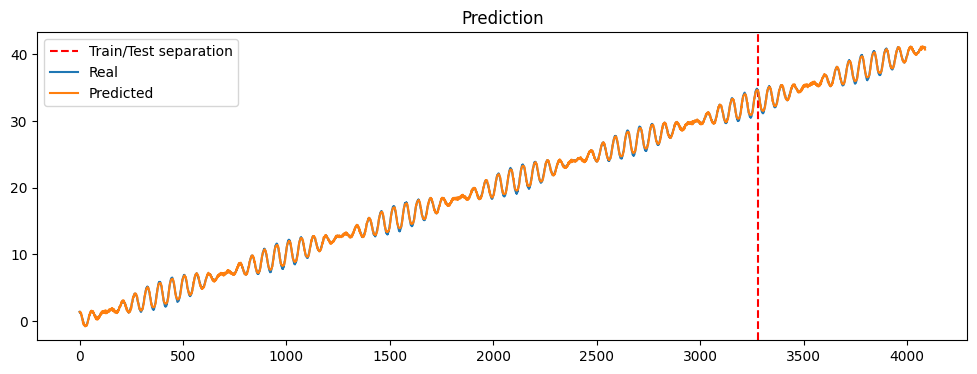

In [ ]:
rnn.eval()
train_predict, h = rnn(x)
time_series_plot(train_predict[0]+y_trend, y+y_trend)

Теперь обучите на этих же данных LSTM с таким же размером скрытого слоя и визуализируйте результат.

In [ ]:
def time_series_train(model, x_t, y_t, num_epochs=1500, learning_rate=0.001):
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        y_pred, h = model(x_t)
        optimizer.zero_grad()

        loss = criterion(y_pred, y_t)
        loss.backward()

        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch: {epoch},".ljust(15), "loss: %1.5f" % (loss.item()))

In [ ]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size, batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, (h, c) = self.lstm(x)
        y = self.fc(h[-1])
        return y, h

In [ ]:
lstm = LSTM(input_size, hidden_size)
time_series_train(lstm, x_train, y_train)

Epoch: 0,       loss: 1.07063
Epoch: 100,     loss: 0.86305
Epoch: 200,     loss: 0.56040
Epoch: 300,     loss: 0.31468
Epoch: 400,     loss: 0.19616
Epoch: 500,     loss: 0.14454
Epoch: 600,     loss: 0.11154
Epoch: 700,     loss: 0.08788
Epoch: 800,     loss: 0.07100
Epoch: 900,     loss: 0.05890
Epoch: 1000,    loss: 0.05007
Epoch: 1100,    loss: 0.04346
Epoch: 1200,    loss: 0.03840
Epoch: 1300,    loss: 0.03444
Epoch: 1400,    loss: 0.03128


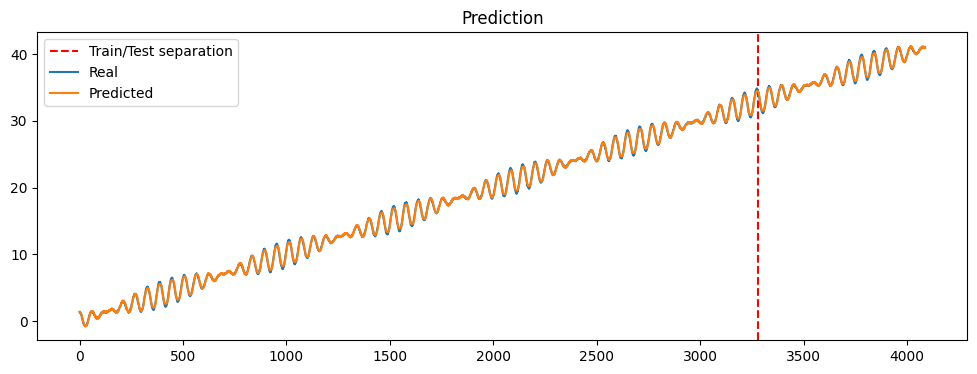

In [ ]:
lstm.eval()
train_predict, h = lstm(x)
time_series_plot(train_predict+y_trend, y+y_trend)

Произведите аналогичные действия с GRU моделью.

In [ ]:
import torch.nn as nn

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_size, hidden_size=hidden_size, batch_first=True
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, h = self.gru(x)
        y = self.fc(h[-1])
        return y, h

In [ ]:
gru = GRU(input_size, hidden_size)
time_series_train(gru, x_train, y_train)

Epoch: 0,       loss: 0.84036
Epoch: 100,     loss: 0.49793
Epoch: 200,     loss: 0.25109
Epoch: 300,     loss: 0.11775
Epoch: 400,     loss: 0.06699
Epoch: 500,     loss: 0.05165
Epoch: 600,     loss: 0.04548
Epoch: 700,     loss: 0.04127
Epoch: 800,     loss: 0.03774
Epoch: 900,     loss: 0.03465
Epoch: 1000,    loss: 0.03192
Epoch: 1100,    loss: 0.02950
Epoch: 1200,    loss: 0.02735
Epoch: 1300,    loss: 0.02544
Epoch: 1400,    loss: 0.02377


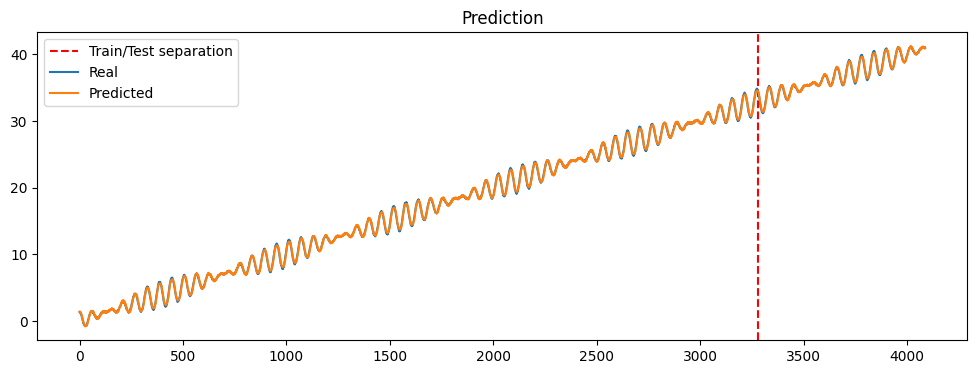

In [ ]:
gru.eval()
train_predict, h = gru(x)
time_series_plot(train_predict+y_trend, y+y_trend)

In [ ]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

def metric(pred, true):
  pred = pred.detach().numpy()
  true = true.detach().numpy()
  mse = mean_squared_error(true, pred)
  print("MSE: " + str(mse))
  mae = mean_absolute_error(true, pred)
  print("MAE: " + str(mae))
  rmse = math.sqrt(mean_squared_error(true, pred))
  print("RMSE: " + str(rmse))

In [ ]:
print("RNN")
predict, h = rnn(x_test)
metric(predict[0], y_test)
print("LSTM")
predict, h = lstm(x_test)
metric(predict, y_test)
print("GRU")
predict, h = gru(x_test)
metric(predict, y_test)

RNN
MSE: 0.01904269
MAE: 0.111080915
RMSE: 0.13799525119810324
LSTM
MSE: 0.027238809
MAE: 0.1353606
RMSE: 0.16504183885394735
GRU
MSE: 0.021470107
MAE: 0.120321035
RMSE: 0.14652681371734283




Сравните результаты и скорость работы RNN, LSTM и GRU.

Лучше всего справился RNN, потом GRU, хуже всего LSTM

Быстрее всех справился RNN, потом GRU, медленне всего LSTM

## Формат результата

Графики предсказания RNN, LSTM, GRU.

Посчитанные метрики.

Пример графика:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX09/result_1_task_ex09.png" width="800">

# Задание 2. Генерация фамилий

Возьмите следующий набор данных и, используя код из лекции, создайте рекуррентную сеть для генерации фамилий. Подумайте, как получить разные фамилии, начинающиеся на одну и ту же букву.

Импорт необходимых библиотек:

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

Для выполнения задания рекомендуется использовать среду с аппаратным ускорителем GPU.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


Загрузка данных:

In [ ]:
!wget -q https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/surnames.txt

In [ ]:
with open("surnames.txt", encoding="utf-8") as s_file:
    surnames_list = [line.strip().lower() for line in s_file.readlines()]

In [ ]:
print(surnames_list)
true_surnames_list = surnames_list.copy()

['иванов', 'кузнецов', 'попов', 'смирнов', 'иванова', 'васильев', 'петров', 'кузнецова', 'волков', 'соколов', 'козлов', 'новиков', 'морозов', 'павлов', 'михайлов', 'федоров', 'смирнова', 'степанов', 'семенов', 'макаров', 'егоров', 'алексеев', 'андреев', 'попова', 'захаров', 'николаев', 'васильева', 'зайцев', 'яковлев', 'романов', 'никитин', 'лебедев', 'петрова', 'сергеев', 'борисов', 'орлов', 'григорьев', 'соловьев', 'киселев', 'кузьмин', 'тарасов', 'воробьев', 'фролов', 'медведев', 'шевченко', 'сорокин', 'жуков', 'ковалев', 'бондаренко', 'баранов', 'поляков', 'филиппов', 'белов', 'дмитриев', 'мельников', 'гусев', 'соколова', 'максимов', 'волкова', 'александров', 'новикова', 'антонов', 'павлова', 'морозова', 'ильин', 'сидоров', 'михайлова', 'матвеев', 'коваленко', 'богданов', 'куликов', 'данилов', 'калинин', 'федорова', 'осипов', 'пономарев', 'макарова', 'назаров', 'власов', 'андреева', 'гаврилов', 'колесников', 'тимофеев', 'семенова', 'миронов', 'беляев', 'захарова', 'алексеева', 'али

In [ ]:
surnames_list.append(' ')
chars = set("".join(surnames_list))
int2char = dict(enumerate(chars))
char2int = {char: ind for ind, char in int2char.items()}
surnames_list.pop()

' '

In [ ]:
char2int

{'й': 0,
 'х': 1,
 'и': 2,
 'ю': 3,
 'в': 4,
 'ц': 5,
 'к': 6,
 'г': 7,
 'р': 8,
 'щ': 9,
 'ъ': 10,
 'о': 11,
 'б': 12,
 'с': 13,
 'у': 14,
 'м': 15,
 'ж': 16,
 ' ': 17,
 'э': 18,
 'ь': 19,
 'а': 20,
 'е': 21,
 'л': 22,
 'ч': 23,
 'ы': 24,
 'з': 25,
 'ф': 26,
 'т': 27,
 'ё': 28,
 'я': 29,
 'н': 30,
 'д': 31,
 'ш': 32,
 'п': 33}

In [ ]:
lengths = [len(sent) for sent in surnames_list]
maxlen = max(lengths)

for i in range(len(surnames_list)):
    while len(surnames_list[i]) < maxlen:
        surnames_list[i] += " "

In [ ]:
input_seq = []
target_seq = []

for i in range(len(surnames_list)):
    input_seq.append(surnames_list[i][:-1])

    target_seq.append(surnames_list[i][1:])

print("Input sequence:".ljust(18), f"'{input_seq[0]}'")
print("Target sequence:".ljust(18), f"'{target_seq[0]}'")

Input sequence:    'иванов    '
Target sequence:   'ванов     '


In [ ]:
for i in range(len(surnames_list)):
    input_seq[i] = [char2int[character] for character in input_seq[i]]
    target_seq[i] = [char2int[character] for character in target_seq[i]]

In [ ]:
import numpy as np

dict_size = len(char2int)
seq_len = maxlen - 1
batch_size = len(surnames_list)


def one_hot_encode(sequence, dict_size, seq_len, batch_size):
    features = np.zeros((batch_size, seq_len, dict_size), dtype=np.float32)

    for i in range(batch_size):
        for u in range(seq_len):
            features[i, u, sequence[i][u]] = 1
    return features


input_seq = one_hot_encode(input_seq, dict_size, seq_len, batch_size)
print(
    "Input shape: {} --> (Batch Size, Sequence Length, One-Hot Encoding Size)".format(
        input_seq.shape
    )
)
print(input_seq[0])

Input shape: (46240, 10, 34) --> (Batch Size, Sequence Length, One-Hot Encoding Size)
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.

In [ ]:
input_seq = torch.Tensor(input_seq)
target_seq = torch.Tensor(target_seq)

In [ ]:
input_seq = input_seq.to(device)
target_seq = target_seq.to(device)

In [ ]:
input_seq.shape

torch.Size([46240, 10, 34])

Обратите внимание, что нейронная сеть обрабатывает фамилии по одной букве. Это не значит, что нужно по одной букве предсказать фамилию. Это означает, что по первой букве генерируется вторая, по второй и вычисленному `hidden_state_1` генерируется третья и т.д.

In [ ]:
import torch.nn as nn

class NextCharacterGenerator(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super().__init__()

        self.rnn = nn.RNN(input_size, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        hidden_0 = torch.zeros(
            1, batch_size, self.rnn.hidden_size
        ).to(device)

        out, hidden = self.rnn(x, hidden_0)

        out = out.contiguous().view(-1, self.rnn.hidden_size)
        out = self.fc(out)

        return out, hidden

In [ ]:
model = NextCharacterGenerator(
    input_size=len(char2int), output_size=len(char2int), hidden_dim=12, n_layers=1
).to(device)

num_epochs = 1000

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1, num_epochs + 1):
    optimizer.zero_grad()
    output, hidden = model(input_seq)
    output = output.to(device)
    loss = criterion(output, target_seq.view(-1).long())
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}/{num_epochs}".ljust(20), end=" ")
        print("Loss: {:.4f}".format(loss.item()))

Epoch: 10/1000       Loss: 2.7067
Epoch: 20/1000       Loss: 2.5067
Epoch: 30/1000       Loss: 2.2725
Epoch: 40/1000       Loss: 2.1018
Epoch: 50/1000       Loss: 1.9770
Epoch: 60/1000       Loss: 1.8782
Epoch: 70/1000       Loss: 1.8012
Epoch: 80/1000       Loss: 1.7464
Epoch: 90/1000       Loss: 1.7066
Epoch: 100/1000      Loss: 1.6774
Epoch: 110/1000      Loss: 1.6554
Epoch: 120/1000      Loss: 1.6380
Epoch: 130/1000      Loss: 1.6231
Epoch: 140/1000      Loss: 1.6101
Epoch: 150/1000      Loss: 1.5982
Epoch: 160/1000      Loss: 1.5875
Epoch: 170/1000      Loss: 1.5778
Epoch: 180/1000      Loss: 1.5691
Epoch: 190/1000      Loss: 1.5612
Epoch: 200/1000      Loss: 1.5540
Epoch: 210/1000      Loss: 1.5475
Epoch: 220/1000      Loss: 1.5417
Epoch: 230/1000      Loss: 1.5364
Epoch: 240/1000      Loss: 1.5318
Epoch: 250/1000      Loss: 1.5276
Epoch: 260/1000      Loss: 1.5239
Epoch: 270/1000      Loss: 1.5205
Epoch: 280/1000      Loss: 1.5174
Epoch: 290/1000      Loss: 1.5147
Epoch: 300/100

In [ ]:
def predict(model, character):
    character = np.array([[char2int[c] for c in character]])
    character = one_hot_encode(character, dict_size, character.shape[1], 1)
    character = torch.from_numpy(character).to(device)

    out, hidden = model(character)
    prob = nn.functional.softmax(out[-1], dim=0).data
    char_ind = torch.max(prob, dim=0)[1].item()
    return int2char[char_ind], hidden


def sample(model, out_len, start="hey"):
    model.eval()
    start = start.lower()
    chars = [ch for ch in start]
    size = out_len - len(chars)
    for _ in range(size):
        char, h = predict(model, chars)
        chars.append(char)
    return "".join([char for char in chars if char != ' '])

In [ ]:
print(sample(model, maxlen, "а"))
print(sample(model, maxlen, "б"))
print(sample(model, maxlen, "в"))
print(sample(model, maxlen, "г"))

аренков
баренков
варов
гаренко


## Формат результата

Модель, генерирующая фамилии по первой букве.

Пример:

а — Аркова

б — Банова

в — Варенков

г — Гаранков

# Задание 3. Прогнозирование многомерного временного ряда.

Попробуйте свои силы в анализе многомерных данных. Особенностью таких задач является то, что признаки не являются независимыми и разумно анализировать их одновременно.

В качестве датасета предлагаем [курс биткоина](https://finance.yahoo.com/quote/BTC-USD/history?period1=1410912000&period2=1642118400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true) за не менее чем 3 года.

Рекомендуем использовать модель LSTM.

Установка и импорт необходимых библиотек:

In [3]:
!pip install -q mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.6 MB/s eta 0:00:00


In [4]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import mplfinance as mpf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

Загрузка и разведочный анализ данных:

In [5]:
!wget -q https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/BTC-USD.csv

In [6]:
df = pd.read_csv("BTC-USD.csv", index_col="Date", parse_dates=True)
df.drop(columns=["Adj Close"], inplace=True)
df.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2017-11-29,10077.400391,11517.400391,9601.030273,9888.610352,11568799744
2017-11-30,9906.790039,10801.000000,9202.049805,10233.599609,8310689792
2017-12-01,10198.599609,11046.700195,9694.650391,10975.599609,6783119872
2017-12-02,10978.299805,11320.200195,10905.099609,11074.599609,5138500096
2017-12-03,11082.700195,11858.700195,10862.000000,11323.200195,6608309760


У нас есть ежедневные исторические данные о ценах:

* цена открытия,
* верхняя цена,
* нижняя цена,
* объем торгов.

Наша цель — взять некоторую последовательность из четырех вышеуказанных значений (скажем, за 100 предыдущих дней) и спрогнозировать целевую переменную на следующие 50 дней в будущем.

Визуализируем целевую переменную.

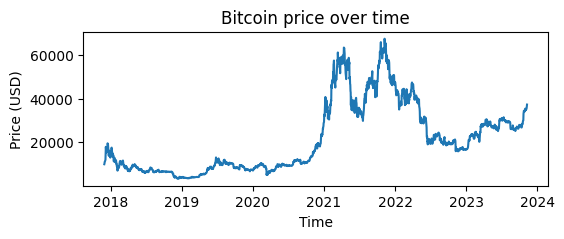

In [7]:
plt.rcParams["figure.figsize"] = (6, 2)

plt.plot(df["Close"])
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.title("Bitcoin price over time")
plt.savefig("initial_plot.png", dpi=250)
plt.show();

Давайте выведим график в более симпатичном виде.

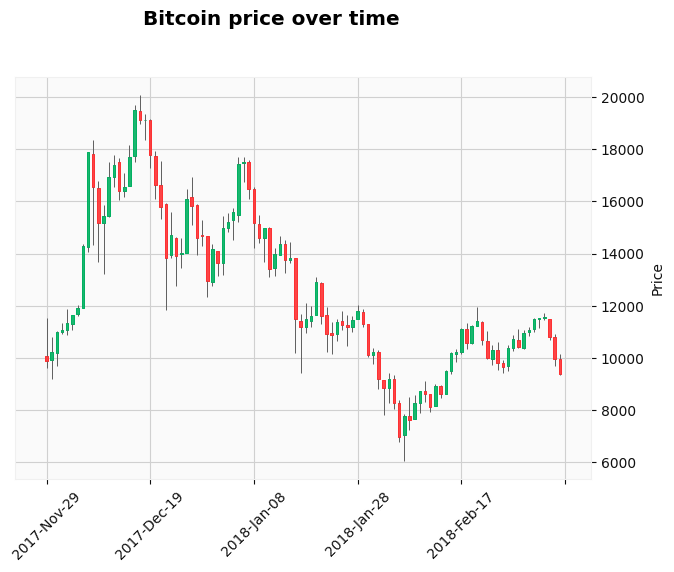

In [8]:
import mplfinance as mpf

mpf.plot(df[:100], type="candle", style="yahoo", title="Bitcoin price over time")

Выделим признаки и целевую переменную.
Здесь представлена относительно небольшая часть данных.

In [9]:
x, y = df.drop(columns=["Close"]), df.Close.values
x.shape, y.shape

((2173, 4), (2173,))

**Нормировка**

Явного тренда не наблюдается. Поэтому только стандартизуем признаки.
Целевая переменная также варьируется в широком диапазоне.

Разделите данные на подвыборки.

Подумайте, как вы будете нормировать признаки и целевую переменную. Одинаково или по-разному?

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

ss = StandardScaler()
x_trans = ss.fit_transform(x)

mm = MinMaxScaler()
y_trans = mm.fit_transform(y.reshape(-1, 1)).flatten()

Требуется подать в модель 100 значений до текущего дня и спрогнозировать следующие 50 значений временного шага.

Требуется получать 100 выборок из `x`, брать 50 следующих индексов в `y` и их объединять.

In [11]:
# split a multivariate sequence into samples
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    x, y = list(), list()  # instantiate X and y
    for i in range(len(input_sequences)):
      end_ix = i + n_steps_in
      if end_ix + n_steps_out > len(input_sequences):
        break
      seq_x = input_sequences[i:end_ix]
      seq_y = output_sequence[end_ix:end_ix + n_steps_out]
      x.append(seq_x)
      y.append(seq_y)
    return np.array(x), np.array(y)

In [12]:
x_ss, y_mm = split_sequences(x_trans, y_trans, 100, 50)
print(x_ss.shape, y_mm.shape)

(2024, 100, 4) (2024, 50)


Давайте проверим, что первая выборка в `y_mm` действительно начинается с сотой выборки в исходном целевом векторе `y`.

In [13]:
print(y_mm[0])
y_trans[100:100 + 50]

[0.09483572 0.08750556 0.09858327 0.09277712 0.09261747 0.07823788
 0.07872056 0.07930332 0.07275165 0.0775208  0.08384709 0.08824347
 0.08848924 0.08536767 0.08771728 0.08442955 0.08175055 0.07729883
 0.07144837 0.07333613 0.06107468 0.05679705 0.05808743 0.05607748
 0.05980156 0.06558905 0.05622687 0.05556824 0.05284556 0.05711681
 0.05886452 0.05493494 0.05593027 0.05800644 0.07232214 0.07242645
 0.07382984 0.0791597  0.07495575 0.07252174 0.07658407 0.07861873
 0.08719202 0.08796537 0.08651784 0.0885141  0.10043108 0.08719062
 0.09396459 0.08938726]


array([0.09483572, 0.08750556, 0.09858327, 0.09277712, 0.09261747,
       0.07823788, 0.07872056, 0.07930332, 0.07275165, 0.0775208 ,
       0.08384709, 0.08824347, 0.08848924, 0.08536767, 0.08771728,
       0.08442955, 0.08175055, 0.07729883, 0.07144837, 0.07333613,
       0.06107468, 0.05679705, 0.05808743, 0.05607748, 0.05980156,
       0.06558905, 0.05622687, 0.05556824, 0.05284556, 0.05711681,
       0.05886452, 0.05493494, 0.05593027, 0.05800644, 0.07232214,
       0.07242645, 0.07382984, 0.0791597 , 0.07495575, 0.07252174,
       0.07658407, 0.07861873, 0.08719202, 0.08796537, 0.08651784,
       0.0885141 , 0.10043108, 0.08719062, 0.09396459, 0.08938726])

Будем предсказывать данные на несколько месяцев вперед.

Возьмём для обучения 90% данных, на тест — 10%. Как раз их и требуется предсказать.

In [14]:
train_test_cutoff = 0.9
num_samples = len(y_mm)
split_index = int(num_samples * train_test_cutoff)
x_train, x_test = x_ss[:split_index], x_ss[split_index:]
y_train, y_test = y_mm[:split_index], y_mm[split_index:]

In [15]:
print("Training Shape:", x_train.shape, y_train.shape)
print("Testing Shape:", x_test.shape, y_test.shape)

Training Shape: (1821, 100, 4) (1821, 50)
Testing Shape: (203, 100, 4) (203, 50)


Переведём данные в тензоры для подачи в модель.

In [16]:
x_train_tensors = torch.Tensor(x_train)
x_test_tensors = torch.Tensor(x_test)

y_train_tensors = torch.Tensor(y_train)
y_test_tensors = torch.Tensor(y_test)

В зависимости от того, как вы организуете данные и модель, вам может потребоваться привести данные к такой форме, которую сможет принять модель. Используйте `torch.reshape`.

In [17]:
x_train_tensors_final = x_train_tensors
x_test_tensors_final = x_test_tensors

In [18]:
print("Training Shape:", x_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", x_test_tensors_final.shape, y_test_tensors.shape)

Training Shape: torch.Size([1821, 100, 4]) torch.Size([1821, 50])
Testing Shape: torch.Size([203, 100, 4]) torch.Size([203, 50])


**Модель LSTM**

Вы можете реализовать модель как через слой `LSTM`, так и через `LSTMCell`.

Возможно, вам будет полезен параметр `dropout` в этих слоях.

In [73]:
class LSTM(nn.Module):
    def __init__(self, num_lstm_layers, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_state = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_lstm_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, (h_n, c_n) = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

**Обучение**

Реализуйте цикл обучения.

В качестве loss-функции вы можете использовать как обычный MSE, так и что-то более подходящее на ваш взгляд.

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [79]:
def training_loop(num_epochs, model, optimiser, criterion, train_input, train_target,
                  test_input, test_target):
    model.to(device)
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        def closure():
            optimiser.zero_grad()
            out = model(train_input.to(device))
            loss = criterion(out.to(device), train_target.to(device))
            loss.backward()
            return loss

        model.train()
        optimiser.step(closure)

        if epoch % 100 == 0:
          print(f"{epoch}")

Задайте параметры сети.

In [84]:
import warnings
warnings.filterwarnings('ignore')

num_epochs = 401
learning_rate = 0.001


input_size = 4
hidden_size = 64
num_lstm_layers = 2

output_size = 50

lstm = LSTM(num_lstm_layers, input_size, hidden_size, output_size)

Задайте loss-функцию и оптимизатор. Отметьте, что вам нужен loss для регрессии.

In [85]:
import torch.optim as optim

loss_fn = nn.MSELoss()
optimiser = optim.LBFGS(lstm.parameters(), lr=learning_rate)

Запустите цикл обучения

In [86]:
training_loop(
    num_epochs=num_epochs,
    model=lstm,
    optimiser=optimiser,
    criterion=loss_fn,
    train_input=x_train_tensors_final,
    train_target=y_train_tensors,
    test_input=x_test_tensors_final,
    test_target=y_test_tensors,
)

0
100
200
300
400


**Предсказание**

Обратите внимание на то, что вы передаёте в модель. И так ли эти данные выглядят, как те, на которых модель училась.

Постройте график предсказания для всего набора данных.

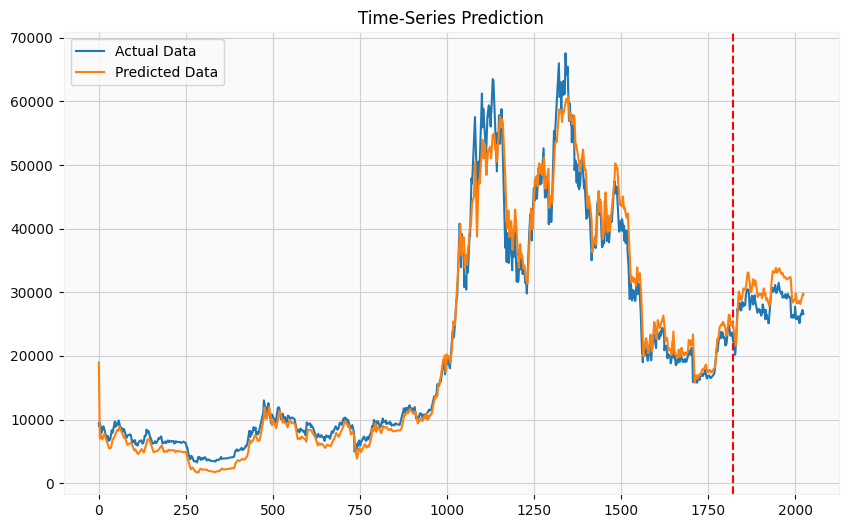

In [87]:
df_x_ss = ss.transform(df.drop(columns=['Close'])) # old transformers
df_y_mm = mm.transform(df.Close.values.reshape(-1, 1)).flatten() # old transformers

# split the sequence
df_x_ss, df_y_mm = split_sequences(df_x_ss, df_y_mm, 100, 50)

# converting to tensors
df_x_ss = torch.tensor(df_x_ss, dtype=torch.float32)
df_y_mm = torch.tensor(df_y_mm, dtype=torch.float32)

# # reshaping the dataset
# df_x_ss = # Your code here

# forward pass
lstm.eval()
with torch.no_grad():
    train_predict = lstm(df_x_ss.to(device))
data_predict = mm.inverse_transform(train_predict.cpu().numpy())
data_y_plot = mm.inverse_transform(df_y_mm.cpu().numpy())

true, preds = [], []
for i in range(len(data_y_plot)):
    true.append(data_y_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=num_samples * train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show()

Как вам результат?

Если вы подали достаточно данных и смотрите не слишком далеко за красную линию, вы должны увидеть, что **ваша модель удивительно точна** в прогнозировании цены на несколько месяцев вперед.

Однако то, что здесь происходит, является **утечкой данных**: информация о таргетах просочилась в тестовые признаки.

То есть всякий раз, когда мы запускаем модель, она имеет доступ к цене открытия на этот день, которая, очевидно, будет очень близка к цене в конечном итоге для этого конкретного временного шага. Когда мы перебираем наши прогнозы по модели, мы добавляем первое предсказанное значение для этого временного шага. Это означает, что каждое предсказание, которое мы здесь строим, имеет то преимущество, что оно является следующим предсказанным значением, а не последовательностью из 50 значений в будущем.

**Как надо:** передать 100 временных шагов перед последним значением в тесте, а затем использовать **один раз** `forward` модели, чтобы предсказать следующие 50 временных шагов.

In [91]:
test_predict = lstm(x_test_tensors_final[-1].unsqueeze(0).to(device))  # get the last sample
test_predict = test_predict.detach().cpu().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors[-1].detach().numpy()  # last sample again
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

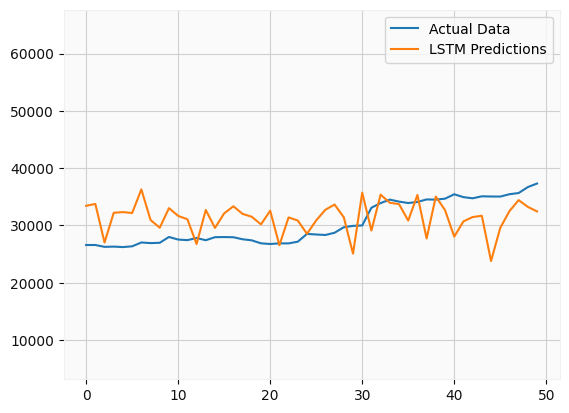

In [98]:
plt.plot(test_target, label="Actual Data")
plt.plot(test_predict, label="LSTM Predictions")
plt.ylim(min(y) - 100, max(y) + 100)
plt.legend()
plt.savefig("small_plot.png", dpi=300)
plt.show();

Результат является хорошим, если реальные и предсказанные значения имеют один тренд.

В качестве последнего графика давайте посмотрим на масштаб данных.

**Настройте этот масштаб под ваши данные!**

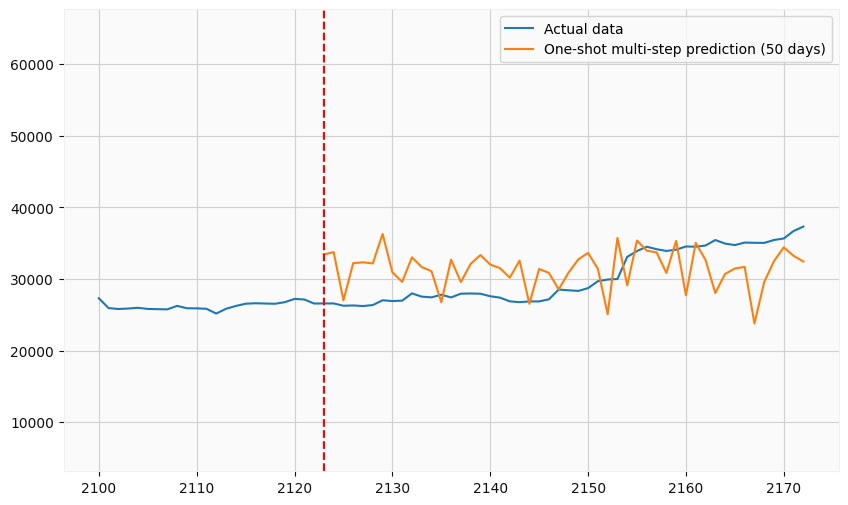

In [99]:
plt.figure(figsize=(10, 6))  # plotting
a = [x for x in range(2100, len(y))]
plt.plot(a, y[2100:], label="Actual data")
c = [x for x in range(len(y) - 50, len(y))]
plt.plot(c, test_predict, label="One-shot multi-step prediction (50 days)")
plt.axvline(x=len(y) - 50, c="r", linestyle="--")
plt.ylim(min(y) - 100, max(y) + 100)
plt.legend()
plt.savefig("final_plot.png", dpi=300)
plt.show()

Ваш результат отчётливо зависит от того среза данных, который вы используете.

Т.е. от того, не поменял ли ряд свой профиль после красной линии.

**Дополнительно**

* Взять больше исторических данных и попробовать улучшить свою модель. А также проверить её на различных участках ряда.

* Реализовать кросс-валидацию на временных рядах

## Формат результата

График с предсказанием, численная метрика оценки качества предсказания

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX09/result_3_task_ex09.png" width="600">

# Задание 4*. Посимвольная генерация текста

Возьмите произведение Гете "Фауст" и обучите на нем LSTM модель для посимвольной генерации текста. Вместо one-hot кодирования используйте `nn.Embedding` ([ссылка](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html), [ссылка](https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html)). При обучении игнорируйте знаки препинания и номера страниц.


Импорт необходимых библиотек:

In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

Для выполнения задания рекомендуется использовать среду с аппаратным ускорителем GPU.

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


Загрузка данных:

In [36]:
!wget -q https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/Faust.txt

In [38]:
with open("Faust.txt") as text_file:
    faust_text = "".join(text_file.readlines())

In [39]:
import re

text = re.sub(r'[^A-Za-zА-Яа-яёЁ\s]', '', faust_text)
text = text.lower()

In [40]:
chars = sorted(set(text))
char_to_idx = {ch: idx for idx, ch in enumerate(chars)}
idx_to_char = {idx: ch for idx, ch in enumerate(chars)}

encoded_text = [char_to_idx[ch] for ch in text]

In [45]:
sequence_length = 100
step = 1

sequences = []
next_chars = []

for i in range(0, len(encoded_text) - sequence_length, step):
    sequences.append(encoded_text[i:i + sequence_length])
    next_chars.append(encoded_text[i + sequence_length])

x = torch.tensor(sequences)[:1000,:]
y = torch.tensor(next_chars)[:1000]

In [52]:
class CharLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(CharLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x

In [43]:
vocab_size = len(chars)
embedding_dim = 128
hidden_dim = 256

model = CharLSTM(vocab_size, embedding_dim, hidden_dim)

In [53]:
num_epochs = 500
learning_rate = 0.001
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.to(device)
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(x.to(device))
    loss = loss_function(output.to(device), y.to(device))
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

Epoch 1/500, Loss: 1.7045507431030273
Epoch 2/500, Loss: 1.8724955320358276
Epoch 3/500, Loss: 1.7119896411895752
Epoch 4/500, Loss: 1.6906324625015259
Epoch 5/500, Loss: 1.6900789737701416
Epoch 6/500, Loss: 1.6741447448730469
Epoch 7/500, Loss: 1.6358213424682617
Epoch 8/500, Loss: 1.591914415359497
Epoch 9/500, Loss: 1.5585612058639526
Epoch 10/500, Loss: 1.5355944633483887
Epoch 11/500, Loss: 1.5155481100082397
Epoch 12/500, Loss: 1.494062900543213
Epoch 13/500, Loss: 1.4688564538955688
Epoch 14/500, Loss: 1.4402832984924316
Epoch 15/500, Loss: 1.4109607934951782
Epoch 16/500, Loss: 1.3820223808288574
Epoch 17/500, Loss: 1.3540538549423218
Epoch 18/500, Loss: 1.3269304037094116
Epoch 19/500, Loss: 1.2997514009475708
Epoch 20/500, Loss: 1.2718664407730103
Epoch 21/500, Loss: 1.2438380718231201
Epoch 22/500, Loss: 1.2152597904205322
Epoch 23/500, Loss: 1.1860766410827637
Epoch 24/500, Loss: 1.156644344329834
Epoch 25/500, Loss: 1.1272920370101929
Epoch 26/500, Loss: 1.098421216011047

In [54]:
def generate_text(model, start_string, gen_length=100):
    model.eval()
    input_eval = torch.tensor([char_to_idx[ch] for ch in start_string]).unsqueeze(0)
    generated_text = start_string

    for _ in range(gen_length):
        predictions = model(input_eval.to(device))
        predicted_id = torch.multinomial(torch.softmax(predictions, dim=-1), num_samples=1)[-1]
        input_eval = torch.cat((input_eval.to(device), predicted_id.unsqueeze(0).to(device)), dim=1)
        generated_text += idx_to_char[predicted_id.item()]

    return generated_text

start_string = "все"
generated_text = generate_text(model, start_string, gen_length=500)
print(generated_text)

всел песноп веснамя дружной
ви сумро духвой строгий о миренье
в очах слеза сменяется слезой
все чем владею вдаль кудато скрылось
все что прошло  восстало оживилось
директор поэт и комик
друзья вы оба мне не раз
помочь умел ках воменье
туда в ом скало кад юбвеной
стрепо сти во сомика изненье
воссталина ве срашной
и образы мир дует
и жиз смненой саровая ете смолаза
вире то скрошло в утора
в оживи сем хней роба
ома чт овак вдало юнвой
и строги коми смена вяной
во суробеке рдапе сременья
все что прошло


Если сделать модель сложнее или дать ей на взод больше данных(gpu не хвтатет, поэтому взял[:1000]), то модель будет предсказывать лучше, еще можно увеличить количество эпох, но тогда может начаться переобучение

## Формат результата

Сгенерерированный текст

Пример текста:

"все все от бесстыдные старой

все в нем получше все стремленья

поддержки с собой в сердце воздух своей

и в вечной страсти восстанет свой предлог

привет вам слуга в сладком страшней стране

и в мире все вражда станет станет

в поле на пользу своим воспоминанья"
